In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import pathlib
import warnings
warnings.filterwarnings('ignore')
from audio_classification import *
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

MIN_SC = 0.2
MIN_AMP = 1.5
MIN_SAMPLES = 300
NUM_SAMPLES = 600

In [2]:
def even_df(df, target=1000):
    def split(x, t=1000):
        if x == t:
            return [1]
        if x > t:
            return [1] if uniform(0, 1) < t / x else []
        if x < t:
            n = int(t / x)
            return [1] * (n + 1) if uniform(0, 1) < t / x - n else [1] * n
        
    res = df.merge(df.ebird_code.value_counts().to_frame().reset_index().rename(
        columns={'index': 'ebird_code', 'ebird_code': 'cnt'}), on=['ebird_code']).drop(columns=['index'])
    res['split'] = res.cnt.apply(lambda x:split(x,target))
    return splitDataFrameList(res,'split')

# Train

In [3]:
class Dataset():

    def __init__(self, path, df, lables=None):
        self.path = path
        self.dump_path = '/home/mor/Downloads/Birds'
        self.mode = 'train' if lables is None else 'predict'
        self.file_col = 'audio_id' if self.mode=='predict' else 'filename'
        self.df = df.sort_values(by=self.file_col).reset_index()
        self.lables = sorted(df['lable'].unique()) if lables is None else lables
        self.num_rows = NUM_ROWS
        self.num_cols = NUM_COLS
        self.ds = tf.data.Dataset.from_generator(self.iter_train,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=((self.num_rows, self.num_cols, 1), len(self.lables))
                                                 )

    def size(self):
        return len(self.df)

    def get_lable_vec(self, bird):
        res = np.zeros(len(self.lables))
        res[self.lables.index(bird)] = 1
        return res

    def iter_train(self):
        fle = ''
        for ind, row in self.df.iterrows():
            if row[self.file_col] != fle:
                fle = row[self.file_col]
                if self.mode=='train':
                    audio_path = os.path.join(self.path, f"{row['ebird_code']}/{fle}")
                else:
                    audio_path = os.path.join(self.path, f"{fle}.mp3")
                x, sr = librosa.load(audio_path, sr=SR)
            sec = int(row['seconds'])
            xx = x[max(0, sr * (sec - 5)):min(sr * sec, len(x))]
            spec = librosa.feature.mfcc(y=xx, sr=SR, n_mfcc=40)
            for i in range(self.num_cols - spec.shape[1]):
                spec = np.concatenate([spec, spec[:, -1].reshape(spec.shape[0], 1)], axis=1)
            l = [0]*len(self.lables) if self.mode=='predict' else self.get_lable_vec(row['lable'])
            yield spec.reshape(spec.shape[0], spec.shape[1], 1), l

    def to_np(self):
        fle = ''
        X, Y = [], []
        for ind, row in self.df.iterrows():
            sec = int(row['seconds'])
            l = [0] * len(self.lables) if self.mode == 'predict' else self.get_lable_vec(row['lable'])
            dump = os.path.join(self.dump_path, f"{row[self.file_col]}_{sec}.pkl")
            if os.path.isfile(dump):
                r = pickle.load( open( dump, "rb" ) )
            else:
                if row[self.file_col] != fle:
                    fle = row[self.file_col]
                    if self.mode == 'train':
                        audio_path = os.path.join(self.path, f"{row['ebird_code']}/{fle}")
                    else:
                        audio_path = os.path.join(self.path, f"{fle}.mp3")
                    try:
                        x, sr = librosa.load(audio_path, sr=SR)
                    except:
                        print(f"cant load file {audio_path}")
                        continue
                xx = x[max(0, sr * (sec - 5)):min(sr * sec, len(x))]
                spec = librosa.feature.mfcc(y=xx, sr=SR, n_mfcc=40)
                for i in range(self.num_cols - spec.shape[1]):
                    spec = np.concatenate([spec, spec[:, -1].reshape(spec.shape[0], 1)], axis=1)
                r = spec.reshape(spec.shape[0], spec.shape[1], 1)
                pickle.dump( r, open( dump, "wb" ) )
            X.append(r)
            Y.append(l)
            if ind%1000==0:
                print(ind)
        print("-------------- UNPACKING ------------------")
        return np.array(X), np.array(Y)
        
    

In [4]:
# Prepare For Train
df = pd.read_csv('train_full.csv').dropna(subset=['amp_r','sc_r']).drop(columns=['level_0'])
df_train = df[(df.sc_r>MIN_SC)|(df.amp_r>MIN_AMP)]
top_l=df_train.ebird_code.value_counts().to_frame().query(f"ebird_code>{MIN_SAMPLES}").index.values
df_train = df_train[df.ebird_code.isin(top_l)]
df_train['lable'] = df_train.ebird_code
df_train = even_df(df_train,NUM_SAMPLES)
# # Add nobird
# nobird = df[(df.ebird_code.isin(top_l))&((df.sc_r<0.08)&(df.amp_r<1.0)&(df.amp_r>0.5))].sample(NUM_SAMPLES*1)
# nobird.loc[:,'lable']='nocall'
# df_train=pd.concat([df_train,nobird])
print(df_train.lable.value_counts().describe())
lables = sorted(df_train['lable'].unique())
tr_df, ts_df = hash_split(df_train,rate=0.8)
len(tr_df)

count    102.000000
mean     598.725490
std        9.065392
min      578.000000
25%      592.250000
50%      598.500000
75%      605.000000
max      627.000000
Name: lable, dtype: float64


49084

In [9]:
train = Dataset('/home/mor/Downloads/train_audio/',tr_df)
test = Dataset('/home/mor/Downloads/train_audio/',ts_df)
X1,Y1 = train.to_np()
X2,Y2 = test.to_np()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
-------------- UNPACKING ------------------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
-------------- UNPACKING ------------------


In [4]:
lables = pd.read_csv('lables_102.csv').lables.values
X1,Y1,X2,Y2=pickle.load(open(f'x1y1x2y2_{len(lables)}.pkl','rb'))
#pickle.dump((X1,Y1,X2,Y2),open(f'x1y1x2y2_{len(lables)}.pkl','wb'))

In [5]:
#del(model)
num_rows = NUM_ROWS
num_columns = NUM_COLS
num_labels = len(lables)

# Construct model 
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 215, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 107, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 107, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 106, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 53, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 53, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 52, 64)         8

In [7]:
model.fit(X1,Y1,epochs=7,validation_data=(X2,Y2))
model.save(f'model_{len(lables)}.hdf5')

Epoch 1/7
1534/1534 [==============================] - 120s 78ms/step - loss: 4.0996 - accuracy: 0.1118 - val_loss: 3.7126 - val_accuracy: 0.1554
Epoch 2/7
1534/1534 [==============================] - 132s 86ms/step - loss: 2.9423 - accuracy: 0.3066 - val_loss: 3.4674 - val_accuracy: 0.2261
Epoch 3/7
1534/1534 [==============================] - 152s 99ms/step - loss: 2.3850 - accuracy: 0.4240 - val_loss: 3.1890 - val_accuracy: 0.2969
Epoch 4/7
1534/1534 [==============================] - 161s 105ms/step - loss: 2.0407 - accuracy: 0.5025 - val_loss: 3.1885 - val_accuracy: 0.3296
Epoch 5/7
1534/1534 [==============================] - 161s 105ms/step - loss: 1.8337 - accuracy: 0.5459 - val_loss: 3.1559 - val_accuracy: 0.3356
Epoch 6/7
1534/1534 [==============================] - 162s 105ms/step - loss: 1.6822 - accuracy: 0.5797 - val_loss: 3.1860 - val_accuracy: 0.3511
Epoch 7/7
1534/1534 [==============================] - 165s 108ms/step - loss: 1.5917 - accuracy: 0.5998 - val_loss: 3.13

In [36]:
p = model.predict(X2)
l=np.argmax(p, axis=-1)
y=np.argmax(Y2,axis=-1)
pr = [x for x in map(max,p)]
df = pd.DataFrame({'pred':l,'prob':pr,'lable':y})
df['hit']=(df.lable==df.pred).astype(int)
df.hit.mean()

0.36792925079259137

In [25]:
#val=test.df.copy()
# p = model.predict(X2)

# l=[lables[i] for i in np.argmax(model.predict(X2), axis=-1)]
# val['pred'] = l
# val['prob'] = [x for x in map(max,p)]
# val['hit']=val.lable==val.pred.astype(int)
# val.hit.mean()


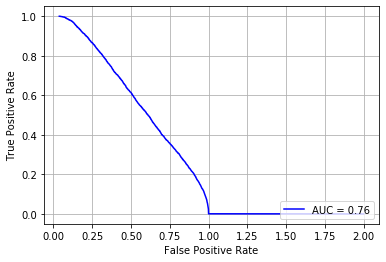

In [69]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(df.hit, df.prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(threshold, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()

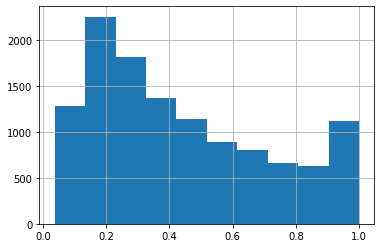

In [38]:
df.prob.hist()

In [65]:
df.hit.sum()

4410

In [61]:
df[df.prob>0.3].hit.sum()

3603

In [66]:
#TPR
3603/4410

0.8170068027210884

In [64]:
df[df.prob>0.3].hit.count()

7094

In [67]:
#FPR
(4410-3603)/4410

0.18299319727891156

In [41]:
df.hit.describe()

count    11986.000000
mean         0.367929
std          0.482262
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: hit, dtype: float64

In [6]:
X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

In [8]:
del(X2)

In [ ]:
for i in range():
    model.fit(X,Y,epochs=1)
    model.save(f'model_{len(lables)}_{i}.hdf5')

1909/1909 [==============================] - 148s 77ms/step - loss: 2.3733 - accuracy: 0.4279


In [11]:
model=tf.keras.models.load_model('model_102C_2.hdf5')
for i in range(4):
    model.fit(X,Y,epochs=1)
    model.save(f'model_{len(lables)}_{i}.hdf5')

1909/1909 [==============================] - 186s 98ms/step - loss: 1.6404 - accuracy: 0.5878


In [15]:
#model = tf.keras.models.load_model('model_60B.hdf5')

In [42]:
pd.DataFrame({'lables':lables}).to_csv(f'lables_{len(lables)}.csv')

In [14]:
X1.shape

(49084,)

In [16]:
df=pd.DataFrame([type(x) for x in X1])

In [21]:
df[df[0]==tuple]

,0
8241,<class 'tuple'>


In [22]:
train.df.loc[8241]

index                                                           33111
Unnamed: 0                                                         83
Unnamed: 0.1                                                       83
rating                                                              5
playback_used                                                      no
ebird_code                                                     normoc
channels                                                     1 (mono)
date                                                       2013-05-13
pitch                                                            both
duration                                                          108
filename                                                 XC172494.mp3
speed                                                            both
species                                          Northern Mockingbird
number_of_notes                                                   4-6
title               

In [31]:
x=pickle.load(open('/home/mor/Downloads/Birds/XC172494.mp3_45.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/mor/Downloads/Birds/XC172494.mp3_45.pkl'

In [29]:
X1[8241]=x[0]

In [30]:
os.remove('/home/mor/Downloads/Birds/XC172494.mp3_45.pkl')

In [36]:
X1=np.stack(X1)